In [1]:
import numpy as np
from   numpy import exp,cos,sin,pi,tan,sqrt,angle,absolute,eye,dot
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn # makes figures prettier (otherwise unused)
from DeDist import dedist
from __future__ import division
import dill
# removes need for plt.show() after every new plot
%matplotlib inline

In [2]:
# Set default figure size
plt.rcParams['figure.figsize'] = (10, 5)

In [12]:
# Restore session state i.e. all objects
# dill.load_session('session_state_het_wid.pkl')

# Save current session state
# dill.dump_session('session_state_het_wid.pkl')

### Random tuning width population coding model

Tuning curve with different tuning widths:
$$g_i(s)=A\exp\Bigg[-\frac{(s-\phi_i)^2}{2\omega_i^2}\Bigg]$$

Amplitude fixed at 1.0

In [55]:
def tuning_curve(pref_stim, stimulus, amplitude=1.0, tuning_width=0.5):
    return amplitude * exp( - (stimulus - pref_stim)**2 / (2 * tuning_width**2) )

def tuning_curve_2d(pref_stim, stim_1, stim_2, amplitude, tuning_width):
    return (tuning_curve(pref_stim, stim_1, amplitude, tuning_width)
            + tuning_curve(pref_stim, stim_2, amplitude, tuning_width))

def tuning_curve_theta(pref_stim, opening_angle, amplitude=1.0, tuning_width=0.5):
    return tuning_curve_2d(pref_stim, opening_angle/2, -opening_angle/2, amplitude, tuning_width)

### Visualisation of population model

Using the uniform distribution: $w_i \sim U(0.1, 1.1)$

Default tuning width previously set to 0.5

In [56]:
def get_tuning_widths(n_neurons):
    return np.random.rand(n_neurons) + 0.1

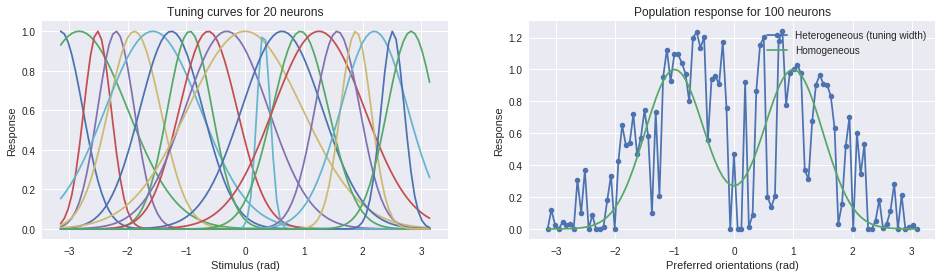

In [57]:
plt.rcParams['figure.figsize'] = (16, 4)

plt.subplot(121)
stim_space = np.linspace(-pi, pi, 100)

n_neurons = 20
pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]

tuning_widths = get_tuning_widths(n_neurons)

for i in range(n_neurons):
    plt.plot(stim_space, tuning_curve(pref_stims[i], stim_space, tuning_width=tuning_widths[i]))

plt.xlabel('Stimulus (rad)')
plt.ylabel('Response')
plt.title('Tuning curves for {0} neurons'.format(n_neurons))

plt.subplot(122)
stim = 2.0

n_neurons = 100
pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
tuning_widths = get_tuning_widths(n_neurons)

plt.plot(pref_stims, tuning_curve_theta(pref_stims, stim, 1.0, tuning_widths), '.-', mew=2, label='Heterogeneous (tuning width)')
plt.plot(pref_stims, tuning_curve_theta(pref_stims, stim), label='Homogeneous')

plt.legend()
plt.xlabel('Preferred orientations (rad)')
plt.ylabel('Response')
plt.title('Population response for {0} neurons'.format(n_neurons))

plt.rcParams['figure.figsize'] = (10, 5)

### Maximum Likelihood decoding

Same as for random amplitude investigation

In [58]:
NOISE_SIGMA = 0.2

In [59]:
# Candidate estimates to evaluate error function
N_CAND_ESTS = 100
CAND_ESTS = np.linspace(0, pi, N_CAND_ESTS+1)[:-1]

# Stimuli (opening angles) for which bias and variance are to be calculated
N_THETAS = 100
THETAS = np.linspace(0, pi/2, N_THETAS)

In [60]:
def get_ML_ests(get_tuning_widths, n_neurons=100, n_realisations=5000):
    biases = np.zeros(N_THETAS)
    variances = np.zeros(N_THETAS)
    estimate_dists = np.zeros((N_THETAS, n_realisations))

    pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    tuning_widths = get_tuning_widths(n_neurons)

    for stim_idx in range(N_THETAS):
        stim = THETAS[stim_idx]

        # Generate noisy pop. responses
        avg_pop_res = tuning_curve_theta(pref_stims, stim, 1.0, tuning_widths)
        pop_responses = avg_pop_res + np.random.normal(scale=NOISE_SIGMA, size=(n_realisations, n_neurons))

        # For each noisy response, compute error wrt candidate stimuli
        avg_tuning_curves = tuning_curve_theta(pref_stims, CAND_ESTS[:,None], 1.0, tuning_widths)
        errors = np.sum((pop_responses-avg_tuning_curves[:,None])**2, axis=2)

        # Find minimum error stimuli for each realisation
        estimate_dists[stim_idx,:] = CAND_ESTS[errors.argmin(axis=0)]

        # Compute bias and variance
        mean_est = estimate_dists[stim_idx,:].mean()
        biases[stim_idx] = mean_est - stim
        variances[stim_idx] = ((estimate_dists[stim_idx,:] - mean_est)**2).mean()
        
    return [estimate_dists, biases, variances]

In [61]:
def get_ML_ests_het(get_tuning_widths, n_repeats=10):
    ML_ests = [0 for _ in range(n_repeats)]
    
    for i in range(n_repeats):
        ML_ests[i] = get_ML_ests(get_tuning_widths)
    
    bias_all = [ML_ests[i][1] for i in range(n_repeats)]
    bias_avg = np.mean(bias_all, axis=0)

    var_all = [ML_ests[i][2] for i in range(n_repeats)]
    var_avg = np.mean(var_all, axis=0)
    
    estimate_dists_avg = np.zeros((N_THETAS, N_CAND_ESTS-1))
    for stim_idx in range(N_THETAS):
        est_probs_all = [get_histogram_probs(ML_ests[i][0][stim_idx,:]) for i in range(n_repeats)]
        estimate_dists_avg[stim_idx,:] = np.mean(est_probs_all, axis=0)
    
    return [estimate_dists_avg, bias_avg, var_avg]

In [62]:
def get_histogram_probs(est_dist):
    weights = np.ones_like(est_dist)/float(len(est_dist))
    hist, bin_edges = np.histogram(est_dist, weights=weights, bins=CAND_ESTS)
    return hist

## Experiments

#### Experiment 1
As an initial experiment, we use the $\texttt{LogNorm}(\mu, \sigma)$ distribution.

We set $\mu$ and $\sigma$ such that the mean is near 0.5

Lognormal
Mean: 0.535261428519
Std: 0.285262413071



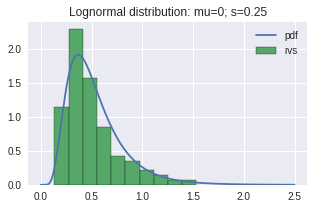

In [63]:
plt.rcParams['figure.figsize'] = (5, 3)

mu = -0.75
sigma = 0.5

X = stats.lognorm(sigma, scale=exp(mu))

x_range = np.linspace(0, 2.5, 1000)
plt.plot(x_range, X.pdf(x_range), label='pdf')
plt.hist(X.rvs(100), normed=True, edgecolor='black', label='rvs')

plt.title('Lognormal distribution: mu=0; s=0.25')
plt.legend()

print 'Lognormal'
print 'Mean:', X.mean()
print 'Std:', X.std()
print '\n',

plt.rcParams['figure.figsize'] = (10, 5)

In [64]:
def get_amplitudes_lognormal(n_neurons):
    mu, sigma = -0.75, 0.5
    return stats.lognorm.rvs(sigma, scale=exp(mu), size=n_neurons)

In [65]:
ests_het_lognorm = get_ML_ests_het(get_amplitudes_lognormal)

In [77]:
hom_fun = lambda n_neurons: np.ones(n_neurons)*0.5
ests_hom = get_ML_ests_het(hom_fun, n_repeats=1)

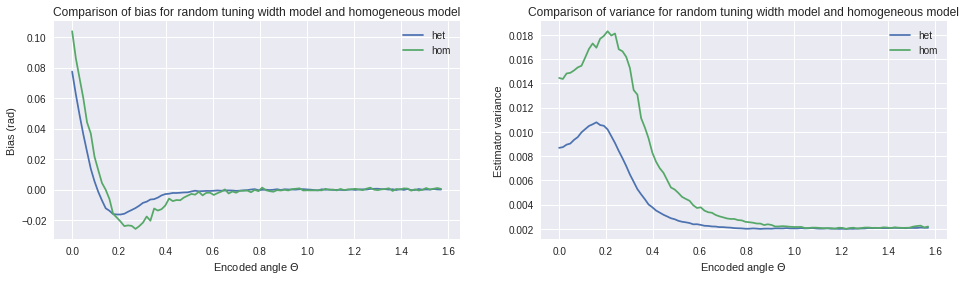

In [8]:
plt.rcParams['figure.figsize'] = (16, 4)

plt.subplot(121)
plt.plot(THETAS, ests_het_lognorm[1], label='het')
plt.plot(THETAS, ests_hom[1], label='hom')

plt.legend()
plt.title('Comparison of bias for random tuning width model and homogeneous model')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')

plt.subplot(122)
plt.plot(THETAS, ests_het_lognorm[2], label='het')
plt.plot(THETAS, ests_hom[2], label='hom')

plt.legend()
plt.title('Comparison of variance for random tuning width model and homogeneous model')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')

plt.rcParams['figure.figsize'] = (10, 5)

We observe a reduction in the bias and variance.

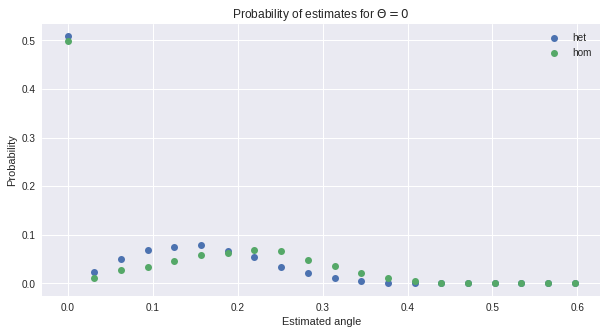

In [18]:
end_idx = 20

est_dist = ests_het_lognorm[0][0]
plt.plot(CAND_ESTS[:end_idx], est_dist[:end_idx], 'o', label='het')

est_dist = ests_hom[0][0]
plt.plot(CAND_ESTS[:end_idx], est_dist[:end_idx], 'o', label='hom')

plt.title('Probability of estimates for $\Theta = 0$')
plt.xlabel('Estimated angle')
plt.ylabel('Probability')
plt.legend()

The above estimate distributions explain the reduction in the bias.

We see that the bell-shaped component of the heterogeneous model has a smaller variance and its peak is shifted to the left.

In [37]:
n_repeats = 10

ML_ests_het_wid_lognorm = [0 for _ in range(n_repeats)]

for i in range(n_repeats):
    ML_ests_het_wid_lognorm[i] = get_ML_ests(get_amplitudes_lognormal)

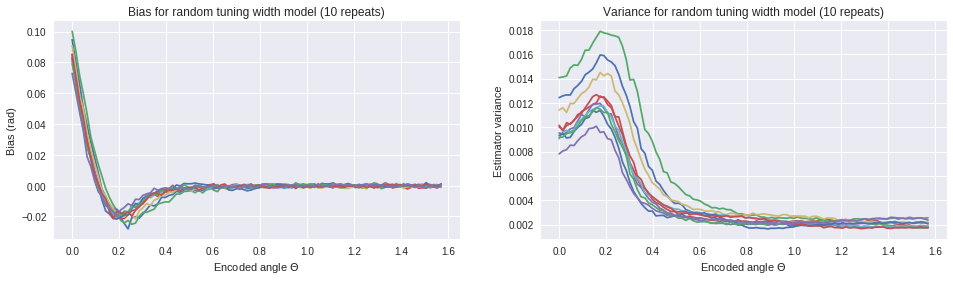

In [46]:
plt.rcParams['figure.figsize'] = (16, 4)

plt.subplot(121)
n_repeats = 10
for i in range(n_repeats):
    plt.plot(THETAS, ML_ests_het_wid_lognorm[i][1])

plt.title('Bias for random tuning width model (10 repeats)')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')
    
plt.subplot(122)
n_repeats = 10
for i in range(n_repeats):
    plt.plot(THETAS, ML_ests_het_wid_lognorm[i][2])

plt.title('Variance for random tuning width model (10 repeats)')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')

plt.rcParams['figure.figsize'] = (10, 5)

The above plots show the results for 10 sets of (sampled) amplitudes (the previous plots showed the mean).

We see considerable fluctation in the bias; in particular at $\Theta = 0$, the bias varies between approximately 0.07 and 0.10

**Functions to get ML estimate only at $\Theta=0$**

In [88]:
def get_ML_ests_stim_0(get_tuning_widths, n_neurons=100, n_realisations=1000):
    stim = 0.0
    estimate_dist = np.zeros(n_realisations)

    pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    tuning_widths = get_tuning_widths(n_neurons)

    # Generate noisy pop. responses
    avg_pop_res = tuning_curve_theta(pref_stims, stim, 1.0, tuning_widths)
    pop_responses = avg_pop_res + np.random.normal(scale=NOISE_SIGMA, size=(n_realisations, n_neurons))

    # For each noisy response, compute error wrt candidate stimuli
    avg_tuning_curves = tuning_curve_theta(pref_stims, CAND_ESTS[:,None], 1.0, tuning_widths)
    errors = np.sum((pop_responses-avg_tuning_curves[:,None])**2, axis=2)

    # Find minimum error stimuli for each realisation
    estimate_dist[:] = CAND_ESTS[errors.argmin(axis=0)]

    # Compute bias and variance
    mean_est = estimate_dist.mean()
    bias = mean_est - stim
    variance = ((estimate_dist - mean_est)**2).mean()

    return [estimate_dist, bias, variance]

def get_ML_ests_het_stim_0(get_tuning_widths, n_neurons=100, n_repeats=10):
    ML_ests = [0 for _ in range(n_repeats)]
    
    for i in range(n_repeats):
        ML_ests[i] = get_ML_ests_stim_0(get_tuning_widths, n_neurons)
    
    bias_all = [ML_ests[i][1] for i in range(n_repeats)]
    bias_avg = np.mean(bias_all)

    var_all = [ML_ests[i][2] for i in range(n_repeats)]
    var_avg = np.mean(var_all)
    
    est_probs_all = [get_histogram_probs(ML_ests[i][0]) for i in range(n_repeats)]
    estimate_dist_avg = np.mean(est_probs_all, axis=0)
    
    return [estimate_dist_avg, bias_avg, var_avg]

#### Experiment 2

We now seek to determine whether the reduction in bias depends on the distribution the tuning widths are sampled from.

We use a truncated normal distribution with $\mu=0.5$ (same value as fixed tuning width previously) and restrict the range to $[0.05, 0.95]$. We vary the variance $\sigma^2$.

Truncated normal
Mean: 0.5
Std: 0.0999928070089



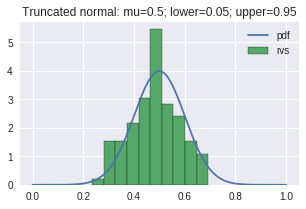

In [10]:
sigma = 0.1

x_range = np.linspace(0, 1.0, 1000)

lower, upper = 0.05, 0.95
mu = 0.5
a = (lower - mu) / sigma
b = (upper - mu) / sigma
X = stats.truncnorm(a, b, loc=mu, scale=sigma)

plt.rcParams['figure.figsize'] = (5, 3)

plt.plot(x_range, X.pdf(x_range), label='pdf')
plt.hist(X.rvs(100), normed=True, edgecolor='black', label='rvs')

plt.title('Truncated normal: mu=0.5; lower=0.05; upper=0.95')
plt.legend()

print 'Truncated normal'
print 'Mean:', X.mean()
print 'Std:', X.std()
print '\n',

plt.rcParams['figure.figsize'] = (10, 5)

In [67]:
def get_tuning_width_trunc_norm(n_neurons, sigma):
    lower, upper = 0.05, 0.95
    mu = 0.5
    a = (lower - mu) / sigma
    b = (upper - mu) / sigma
    return stats.truncnorm.rvs(a, b, loc=mu, scale=sigma, size=n_neurons)

We vary $\sigma$ from 0.01 to 1.0 and evaluate the bias at $\Theta=0$.

In [73]:
sigma_arr = np.linspace(0.01, 1.0, num=100)

ests_het_truncnorm_stim_0 = [0 for _ in range(len(sigma_arr))]

for i in range(len(sigma_arr)):
    tun_wid_fun = lambda n_neurons: get_tuning_width_trunc_norm(n_neurons, sigma_arr[i])
    ests_het_truncnorm_stim_0[i] = get_ML_ests_het_stim_0(tun_wid_fun)

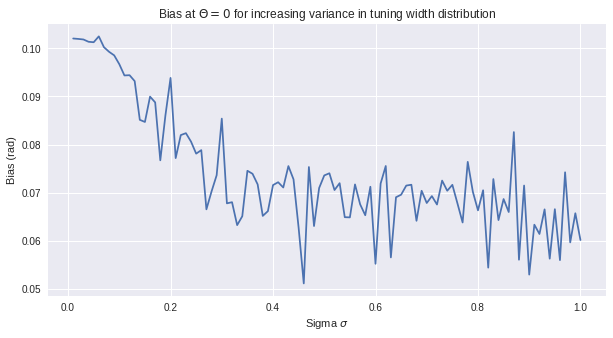

In [11]:
sigma_arr = np.linspace(0.01, 1.0, num=100)
biases = [ests_het_truncnorm_stim_0[i][1] for i in range(len(ests_het_truncnorm_stim_0))]

plt.plot(sigma_arr, biases)

plt.title('Bias at $\Theta=0$ for increasing variance in tuning width distribution')
plt.xlabel('Sigma $\sigma$')
plt.ylabel('Bias (rad)')

For small variance, the bias is identical to the homogeneous model (clearly).

As the variance is increased, the bias initially reduces up to $\sigma=0.4$ and then appears to saturate thereafter.

The points are quite 'noisy'; we will next increase the number of times the set of tuning widths are sampled and reduce the number of stochastic realisations of the response.